### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

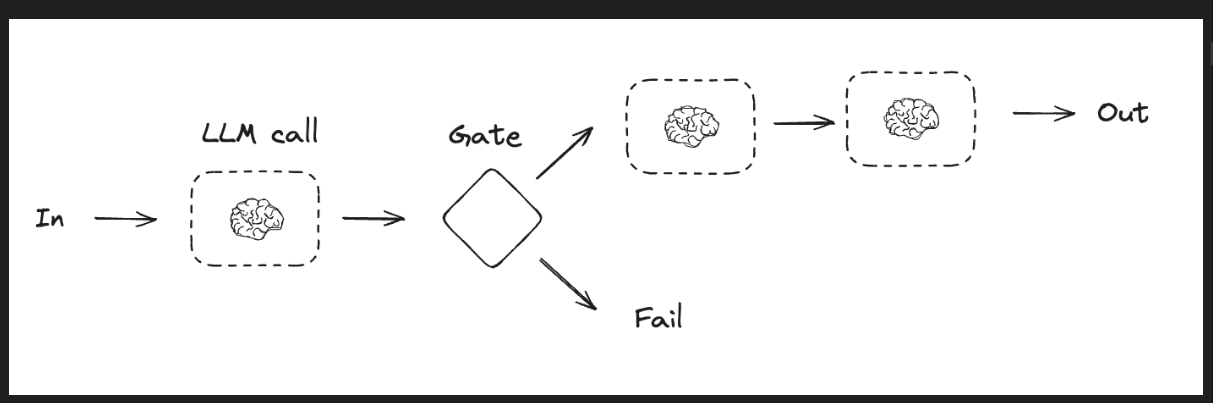

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Graph State
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

from langchain_groq import ChatGroq

llm = ChatGroq(model='gemma2-9b-it', temperature=0.2)



In [3]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}

def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}



In [4]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke",check_punchline,{"Fail":"improve_joke","Pass":END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

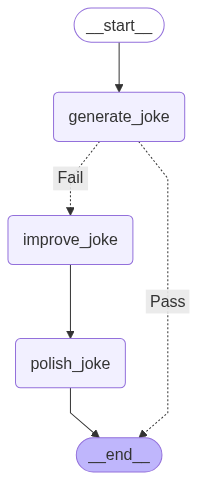

In [5]:
chain

In [6]:
state = chain.invoke({"topic": "rainbow"})

In [7]:
state

{'topic': 'rainbow',
 'joke': 'Why did the rainbow get in trouble at school? \n\nBecause it was always showing off its colors! 🌈  \n',
 'improved_joke': "Why did the rainbow get in trouble at school? \n\nBecause it was always **wavelength**ing its colors! 🌈 \n\n\nLet me know if you'd like to try another joke! 😄 \n",
 'final_joke': 'Here\'s a twist:\n\nWhy did the rainbow get in trouble at school? \n\nBecause it was always **wavelength**ing its colors! 🌈 \n\n**Twist:**  ...and the teacher said, "Look, I get it, you\'re ROYGBIV, but you have to stop making the other kids feel **blue**!"\n\n\nLet me know if you want to try another one! 😄  \n'}

### Parallelization¶
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

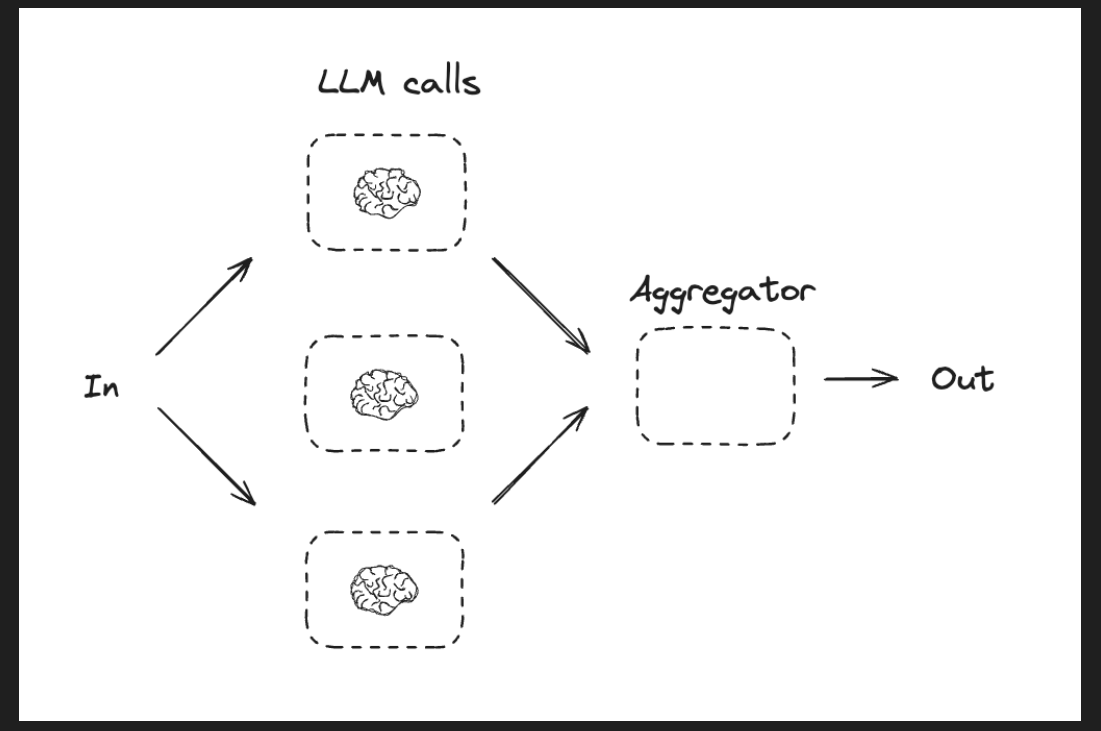

In [8]:
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [9]:
def joker(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def storyteller(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def poet(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}


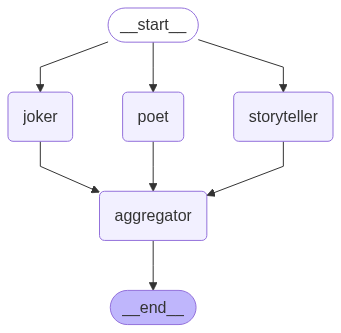

In [10]:
parallel_builder = StateGraph(State)

parallel_builder.add_node("joker", joker)
parallel_builder.add_node("poet", poet)
parallel_builder.add_node("storyteller", storyteller)
parallel_builder.add_node("aggregator", aggregator)

parallel_builder.add_edge(START, "joker")
parallel_builder.add_edge(START, "poet")
parallel_builder.add_edge(START, "storyteller")
parallel_builder.add_edge("joker", "aggregator")
parallel_builder.add_edge("poet", "aggregator")
parallel_builder.add_edge("storyteller", "aggregator")
parallel_builder.add_edge("aggregator", END)



# Compile
parallel_chain = parallel_builder.compile()

parallel_chain

In [11]:
state = parallel_chain.invoke({"topic": "rainbow"})
print(state["combined_output"])

Here's a story, joke, and poem about rainbow!

STORY:
The old woman, Elara, sat on her porch, her wrinkled hands cradling a steaming mug. The air was thick with the scent of rain-soaked earth and the promise of a storm. She watched the clouds gather, their bellies heavy with the promise of tears.

Elara loved storms. They were a reminder of life's constant cycle, of endings and beginnings. And after the storm, she always looked for the rainbow.

This time, the storm was particularly fierce. Thunder roared like a dragon, and lightning split the sky, illuminating the world in stark, fleeting flashes. Elara, however, remained calm, her eyes fixed on the horizon.

Then, just as suddenly as it began, the storm subsided. The rain softened to a gentle drizzle, and the clouds parted, revealing a sliver of blue sky. Elara held her breath.

And there it was.

A rainbow, vibrant and magnificent, arched across the sky. It wasn't just a simple arc of color; it was a tapestry woven with threads of h

### Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

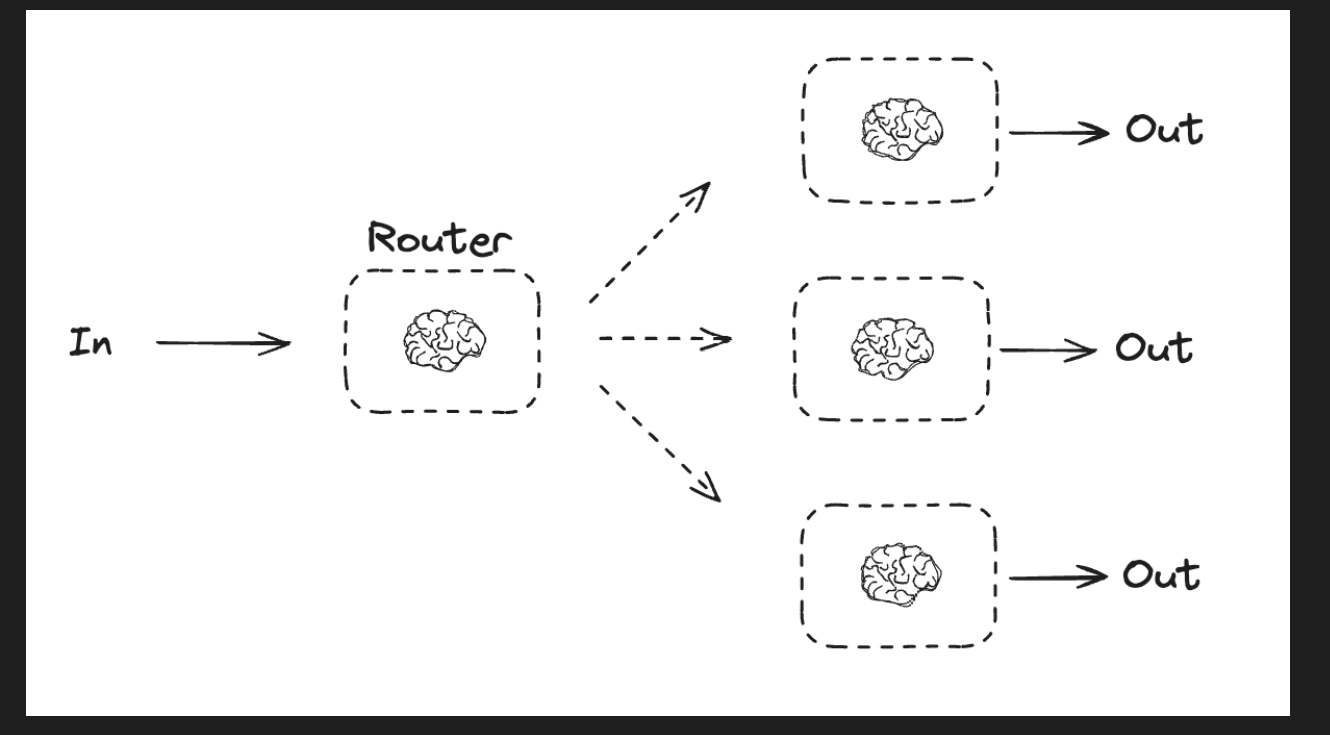

In [22]:
from typing_extensions import Literal, TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


In [23]:
class State(TypedDict):
    input: str
    decision: str
    output: str

In [ ]:
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request.Dont return None or empty string. "
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

    
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


In [25]:


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

router_workflow = router_builder.compile()


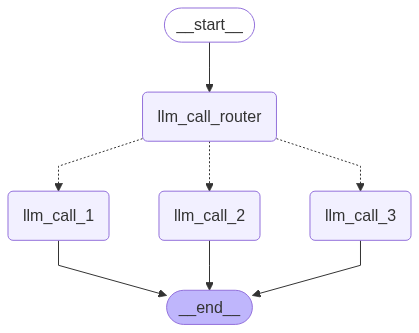

In [26]:
router_workflow

In [27]:
# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

LLM call 2 is called
Why don't cats play poker in the jungle? 

Too many cheetahs! 😹  



### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.
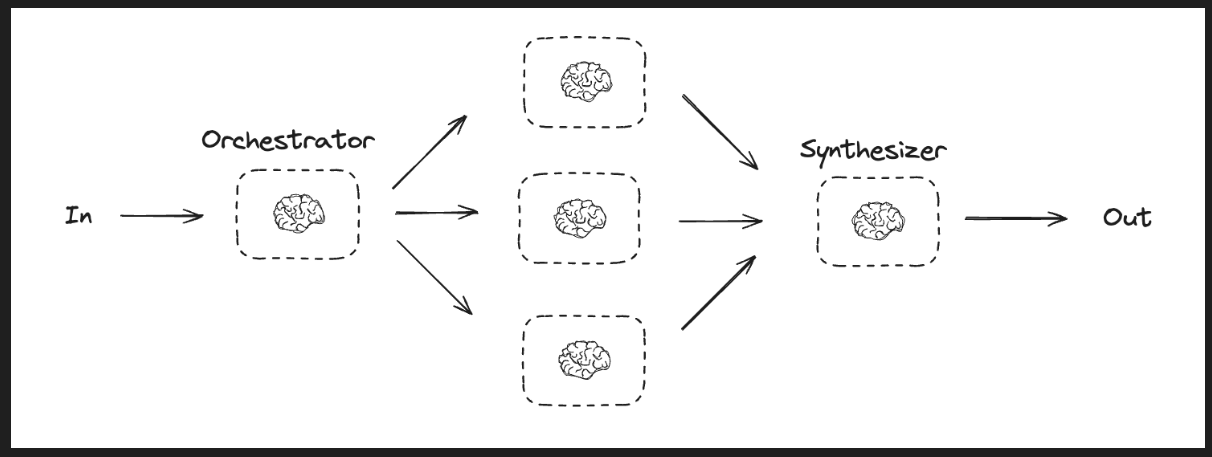

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [29]:

from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [30]:
from typing import TypedDict, Annotated
import operator

class ReportState(TypedDict):
    topic: str
    section_plan: list[Section]
    written_sections: Annotated[list, operator.add]
    full_report: str

class SectionTaskState(TypedDict):
    section: Section
    written_sections: Annotated[list, operator.add]


In [31]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


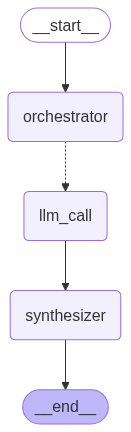

Report Sections: sections=[Section(name='Introduction to Agent AI', description='This section will provide a foundational understanding of Agent AI, exploring its core principles and defining key concepts.'), Section(name='Agent AI RAGs: Features and Capabilities', description='This section will delve into the specific characteristics and functionalities of Agent AI RAGs, highlighting their unique capabilities and limitations.'), Section(name='Applications of Agent AI RAGs', description='This section will examine the various applications of Agent AI RAGs across diverse domains, showcasing real-world examples and potential use cases.'), Section(name='Ethical Considerations and Risks', description='This section will discuss the ethical considerations and potential risks associated with Agent AI RAGs, prompting a critical analysis of their societal impact.'), Section(name='Future Directions and Outlook', description='This section will provide a forward-looking perspective on the future of

## Introduction to Agent AI

Agent AI refers to a branch of artificial intelligence focused on creating autonomous entities, known as agents, capable of perceiving their environment, making decisions, and taking actions to achieve specific goals. 

At its core, Agent AI revolves around the concept of an "agent" which can be defined as a software program or system designed to operate independently within a defined environment. These agents interact with their surroundings through sensors, which provide them with information about the state of the world, and actuators, which allow them to perform actions and modify the environment.

Key concepts in Agent AI include:

* **Autonomy:** Agents operate independently, making decisions and taking actions without constant human intervention.
* **Reactivity:** Agents respond to changes in their environment, adapting their behavior based on perceived stimuli.
* **Proactiveness:**  Agents can take initiative and pursue goals even in the absence of external triggers.
* **Goal-Orientedness:** Agents are designed with specific objectives and strive to achieve them through their actions.
* **Learning:** Many Agent AI systems incorporate learning mechanisms, enabling them to improve their performance over time by analyzing past experiences and adapting their strategies.



These principles and concepts form the foundation for developing a wide range of intelligent agents, from simple chatbots to complex robots capable of navigating and interacting with the physical world. 


---

## Agent AI RAGs: Features and Capabilities

Agent AI RAGs (Retrieval Augmented Generation) are designed to combine the strengths of large language models (LLMs) with external knowledge sources. This allows them to access and process vast amounts of information, enabling more accurate, comprehensive, and contextually relevant responses. 

**Key Features:**

* **Knowledge Integration:** Agent AI RAGs can connect to and query diverse knowledge bases, including databases, APIs, documents, and the internet. This allows them to retrieve specific facts, definitions, and insights relevant to the user's query.
* **Contextual Understanding:** By incorporating retrieved information into their understanding of the conversation, Agent AI RAGs can provide more nuanced and contextually appropriate responses. They can track previous interactions, remember user preferences, and build a richer understanding of the ongoing dialogue.
* **Fact-Based Responses:** Agent AI RAGs are less prone to generating hallucinations or fabricating information, as they rely on factual data retrieved from external sources. This enhances the reliability and trustworthiness of their responses.
* **Personalized Experiences:** Agent AI RAGs can be customized to access specific knowledge bases relevant to a particular domain or user. This allows for tailored and personalized responses based on individual needs and interests.

**Capabilities:**

* **Answering Complex Questions:** Agent AI RAGs can handle complex queries that require multiple pieces of information from different sources. They can synthesize retrieved data and provide comprehensive answers.
* **Summarization and Information Extraction:** Agent AI RAGs can efficiently summarize large amounts of text and extract key information, saving users time and effort.
* **Content Creation:** By leveraging retrieved knowledge, Agent AI RAGs can assist in creating various types of content, such as articles, reports, and presentations.
* **Research and Exploration:** Agent AI RAGs can act as powerful research assistants, helping users explore new topics, gather information, and uncover insights.

**Limitations:**

* **Data Dependency:** The performance of Agent AI RAGs is directly tied to the quality and comprehensiveness of the knowledge sources they access. Inaccurate or incomplete data can lead to flawed responses.
* **Retrieval Challenges:** Finding the most relevant information from vast knowledge bases can be computationally expensive and challenging. 
* **Bias and Fairness:** Like all AI models, Agent AI RAGs can inherit biases present in the training data, potentially leading to unfair or discriminatory outputs.




---

## Applications of Agent AI RAGs

* **Customer Service:** Agent AI RAGs can power chatbots and virtual assistants capable of understanding complex customer queries, accessing relevant information from knowledge bases, and providing accurate and personalized responses. For example, a banking chatbot powered by an RAG can answer questions about account balances, transaction history, and loan options, freeing up human agents to handle more complex issues.

* **Education:** RAGs can be integrated into educational platforms to create personalized learning experiences. They can answer student questions, provide explanations on various topics, and even generate customized learning materials based on individual needs and learning styles.

* **Healthcare:** In healthcare, RAGs can assist doctors and nurses by providing quick access to patient records, medical guidelines, and research papers. This can help improve diagnosis accuracy, treatment planning, and patient care.

* **Research:** Researchers can leverage RAGs to accelerate their work by quickly accessing and synthesizing information from vast amounts of text data. This can be particularly useful in fields like scientific research, legal research, and market analysis.

* **Content Creation:** RAGs can assist writers by generating ideas, summarizing existing content, and even drafting entire articles or reports. This can help overcome writer's block and improve content creation efficiency.

* **Personal Productivity:** RAGs can be integrated into personal productivity tools to help users manage their time, schedule appointments, and track tasks. They can also act as personal assistants, reminding users of important events and helping them stay organized.


These are just a few examples of the many potential applications of Agent AI RAGs. As the technology continues to evolve, we can expect to see even more innovative and impactful uses emerge across a wide range of industries and domains. 


---

## Ethical Considerations and Risks

Agent AI RAGs, while promising in their capabilities, raise several ethical considerations and potential risks that warrant careful analysis:

* **Bias and Fairness:** RAGs are trained on massive datasets which can inadvertently perpetuate existing societal biases. This can result in discriminatory or unfair outputs, reinforcing harmful stereotypes and inequalities.

* **Privacy and Data Security:** RAGs often rely on accessing and processing vast amounts of personal data. Ensuring the privacy and security of this data is crucial, requiring robust safeguards against unauthorized access, misuse, and breaches.

* **Transparency and Explainability:** The decision-making processes of RAGs can be complex and opaque, making it difficult to understand how they arrive at their outputs. This lack of transparency can erode trust and accountability, particularly in high-stakes situations.

* **Misinformation and Manipulation:** RAGs can be used to generate convincing but false information, potentially contributing to the spread of misinformation and manipulation. This poses a threat to informed decision-making and societal cohesion.

* **Job displacement:** The automation capabilities of RAGs may lead to job displacement in certain sectors, requiring careful consideration of the economic and social impacts.

* **Autonomous decision-making:** As RAGs become more sophisticated, concerns arise regarding the potential for autonomous decision-making with unforeseen consequences. Establishing clear ethical guidelines and human oversight is essential.


Mitigating these risks requires a multi-faceted approach involving:

* **Developing ethical guidelines and standards:** Establishing clear ethical principles for the development and deployment of RAGs is crucial.

* **Promoting transparency and explainability:** Researching and implementing techniques to make RAG decision-making processes more transparent and understandable is essential.
* **Addressing bias and fairness:** Actively identifying and mitigating biases in training data and algorithms is crucial for ensuring equitable outcomes.
* **Enhancing data privacy and security:** Implementing robust security measures and privacy-preserving techniques is essential for protecting sensitive data.
* **Fostering public dialogue and engagement:** Encouraging open discussions and public engagement on the ethical implications of RAGs is vital for informed decision-making.


By proactively addressing these ethical considerations and risks, we can harness the potential benefits of Agent AI RAGs while minimizing their potential harms. 


---

## Future Directions and Outlook

* **Enhanced Reasoning and Common Sense:**  Future research will focus on equipping Agent AI RAGs with stronger reasoning capabilities and common sense knowledge. This will involve exploring novel architectures, incorporating symbolic reasoning, and leveraging external knowledge bases to enable more nuanced and human-like understanding.

* **Personalized and Adaptive Agents:**  Agent AI RAGs will become increasingly personalized and adaptive, tailoring their responses and interactions to individual user preferences, contexts, and learning styles. This will require advancements in user modeling, personalization techniques, and dynamic adaptation mechanisms.

* **Multi-Modal Interaction:**  The integration of multiple modalities, such as text, voice, images, and video, will enhance the capabilities and user experience of Agent AI RAGs. This will enable richer interactions, more intuitive understanding, and the ability to handle complex tasks involving diverse data types.

* **Explainability and Trust:**  Addressing the "black box" nature of deep learning models will be crucial for building trust in Agent AI RAGs. Research efforts will focus on developing techniques for explaining agent decisions, providing transparency into reasoning processes, and ensuring ethical and responsible AI development.

* **Real-World Applications:**  Agent AI RAGs will find increasing applications in diverse domains, including education, healthcare, customer service, and entertainment. Their ability to learn, adapt, and interact naturally will revolutionize how we interact with technology and automate complex tasks.




In [32]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])